[*********************100%***********************]  1 of 1 completed


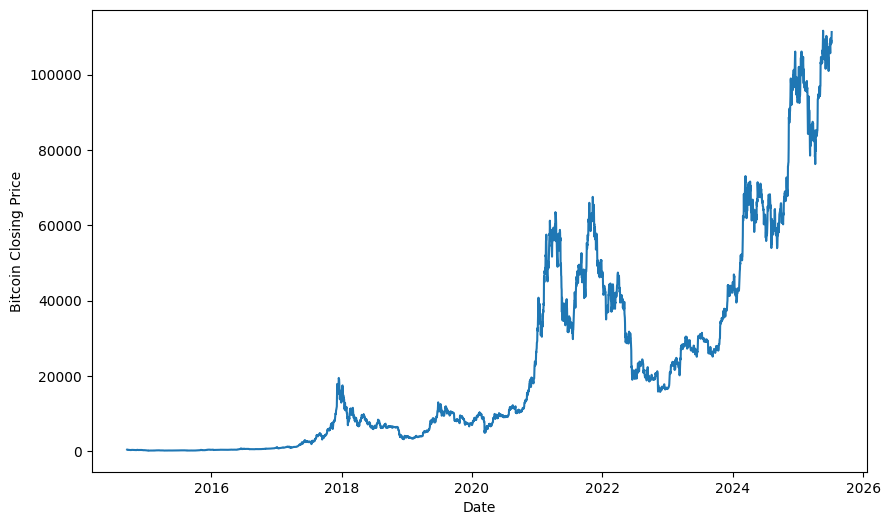

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.api import ARIMA,seasonal_decompose,adfuller
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,root_mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,BaggingRegressor
from xgboost import XGBRegressor
import mlflow
import mlflow.sklearn




bitcoin = yf.download(tickers="BTC-USD",start="2011-01-01",end="2025-07-10")['Close']
bitcoin = bitcoin.reset_index()


df = bitcoin[['Date','BTC-USD']]


df['Date'] = pd.to_datetime(df['Date'])

df = df.set_index('Date')
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
plt.figure(figsize=(10,6))
plt.plot(df)
plt.xlabel("Date")
plt.ylabel("Bitcoin Closing Price")
plt.show()






C:\Users\katsa\AppData\Local\Temp\ipykernel_12024\3287837939.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  decompose.plot().show()


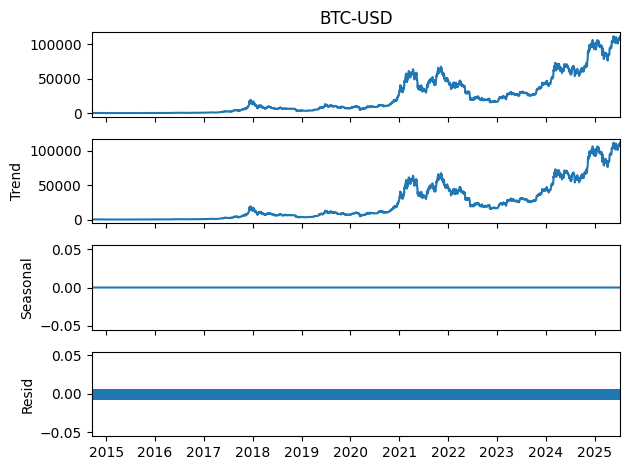

In [6]:
""""Seasonal Decomposition"""

decompose = seasonal_decompose(df['BTC-USD'],model="additive",period=1)
decompose.plot().show()



In [7]:
df1 = df.copy()

def create_values(df1):
    df1 = df1.copy()
    df1['year'] = df1.index.year
    df1['month'] = df1.index.month
    df1['dayofyear'] = df1.index.dayofyear
    df1['day'] = df1.index.day
    df1['quarter'] = df1.index.quarter

    return df1
    
df1 = create_values(df1)

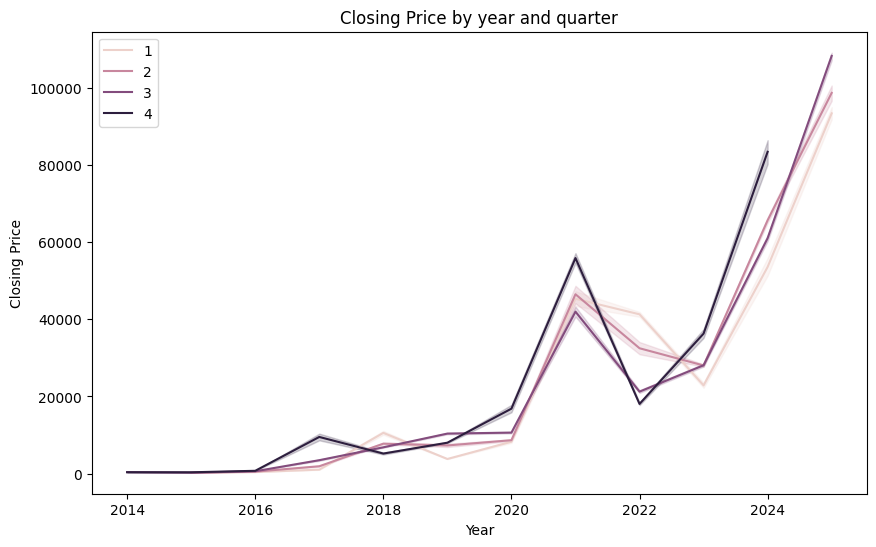

In [4]:
plt.figure(figsize=(10,6))
sns.lineplot(x='year',y='BTC-USD',hue='quarter',data=df1)
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title("Closing Price by year and quarter")
plt.legend()
plt.show()

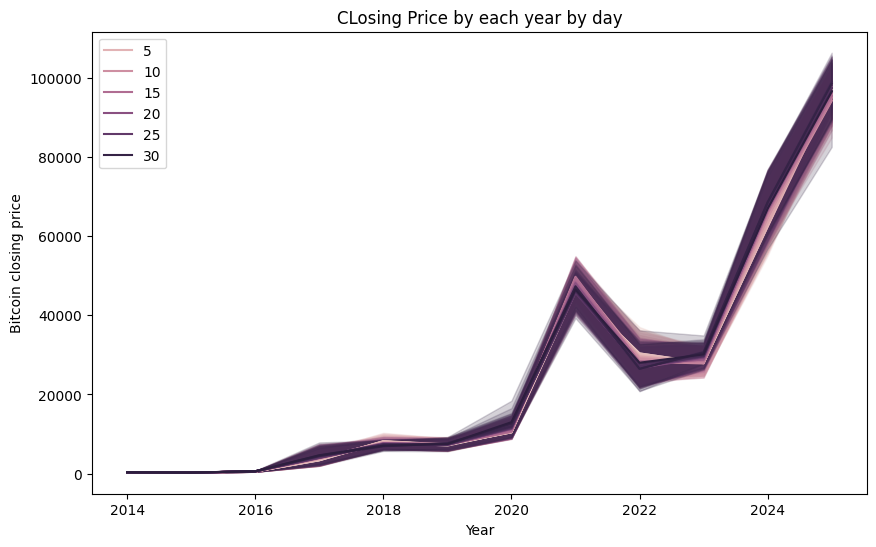

In [8]:
plt.figure(figsize=(10,6))
sns.lineplot(x='year',y='BTC-USD',hue='day',data=df1)
plt.title("CLosing Price by each year by day")
plt.xlabel("Year")
plt.ylabel("Bitcoin closing price")
plt.legend()
plt.show()

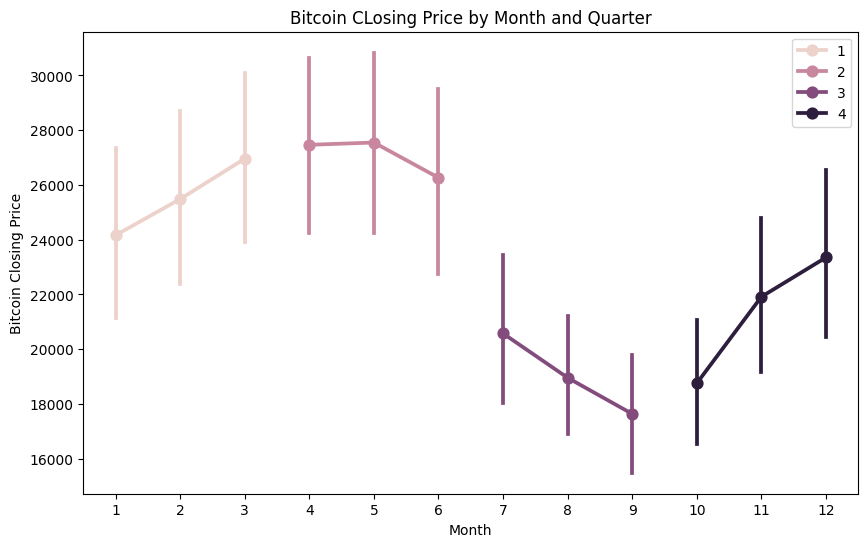

In [9]:
plt.figure(figsize=(10,6))
sns.pointplot(x='month',y='BTC-USD',hue='quarter',data=df1)
plt.xlabel("Month")
plt.ylabel("Bitcoin Closing Price")
plt.title("Bitcoin CLosing Price by Month and Quarter")
plt.legend()
plt.show()

C:\Users\katsa\AppData\Local\Temp\ipykernel_12024\1827980060.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  decomp.plot().show()


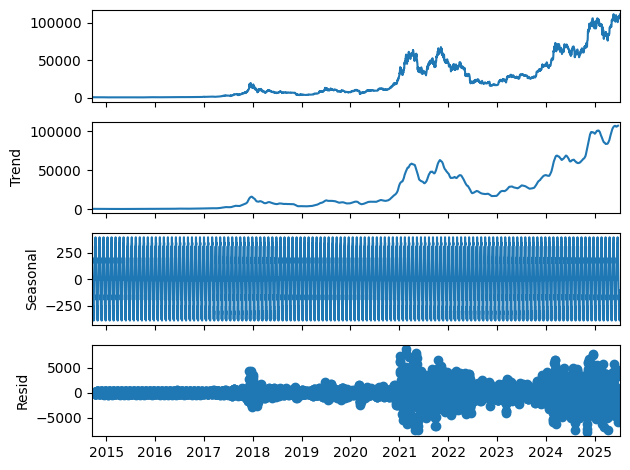

In [10]:
decomp = seasonal_decompose(df,model="additive",period=30)
decomp.plot().show()


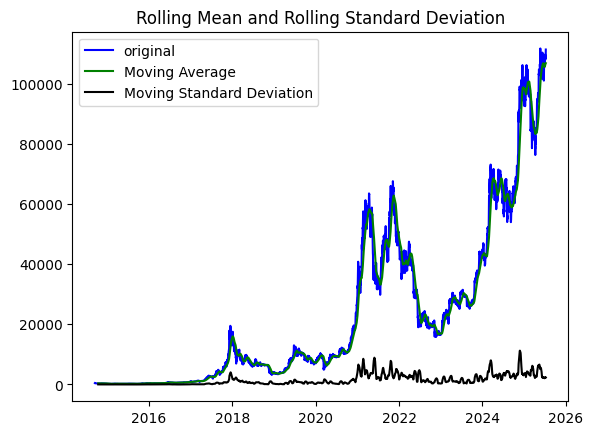

Results from Dickey Fueller

Test Statistic                    0.246668
p-value                           0.974761
'#Lags Used                      31.000000
Number of Observations Used    3914.000000
Critical Value (1%)              -3.432022
Critical Value (5%)              -2.862279
Critical Value (10%)             -2.567163
dtype: float64


In [11]:
"""adfuller for testing stationary"""

def test_stationary(timeseries):
    
    movingaverage = timeseries.rolling(window=30).mean()
    movingstd = timeseries.rolling(window=30).std()
    plt.plot(timeseries,color="blue",label="original")
    plt.plot(movingaverage,color="green",label="Moving Average")
    plt.plot(movingstd,color="black",label="Moving Standard Deviation")
    plt.title("TimeSeries For Bitcoin Closing Prices")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Rolling Standard Deviation")
    plt.show(block=False)
    
    print('Results from Dickey Fueller\n')
    df_test = adfuller(timeseries,autolag="AIC")
    dfoutput = pd.Series(df_test[0:4],index=['Test Statistic','p-value',"'#Lags Used","Number of Observations Used"])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    
test_stationary(df)



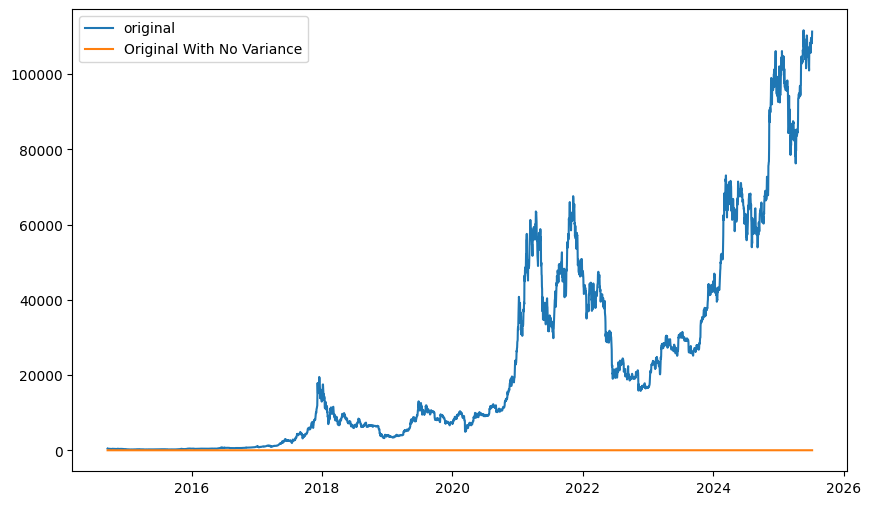

In [12]:
""""Removing variance"""

df_log = np.log(df)

plt.figure(figsize=(10,6))
plt.plot(df,label="original")
plt.plot(df_log,label="Original With No Variance")
plt.legend()
plt.show()


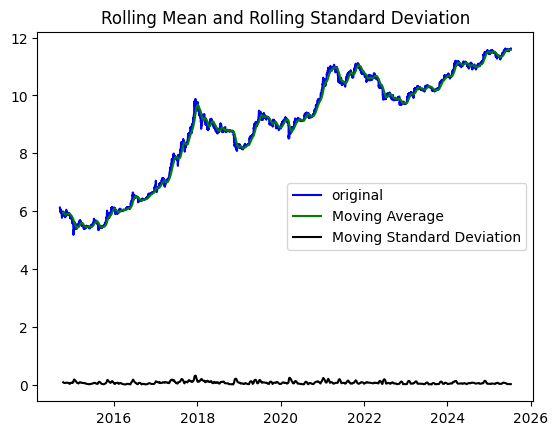

Results from Dickey Fueller

Test Statistic                   -0.829343
p-value                           0.810350
'#Lags Used                      10.000000
Number of Observations Used    3935.000000
Critical Value (1%)              -3.432013
Critical Value (5%)              -2.862275
Critical Value (10%)             -2.567161
dtype: float64


In [13]:
df_log.dropna(inplace=True)


test_stationary(df_log)

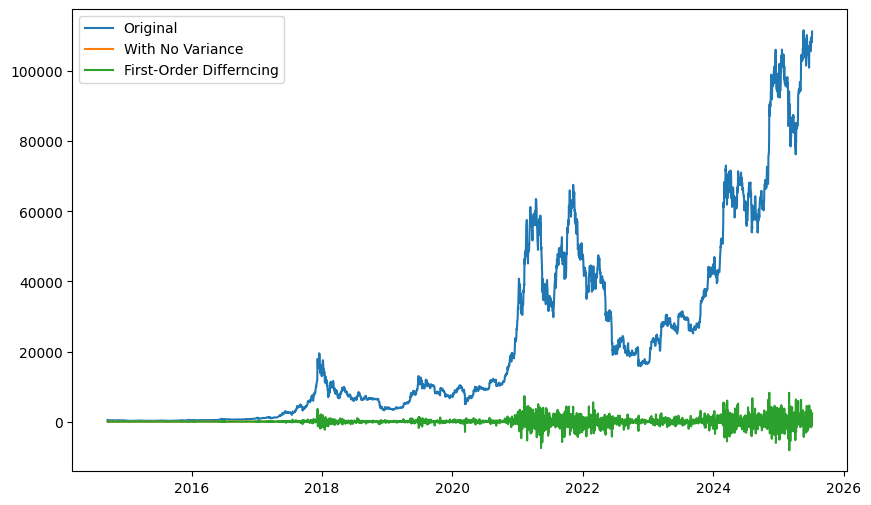

In [14]:
"""first-order condition"""
df_diff = df.diff(1)

plt.figure(figsize=(10,6))
plt.plot(df,label="Original")
plt.plot(df_log,label="With No Variance")
plt.plot(df_diff,label="First-Order Differncing")
plt.legend()
plt.show()


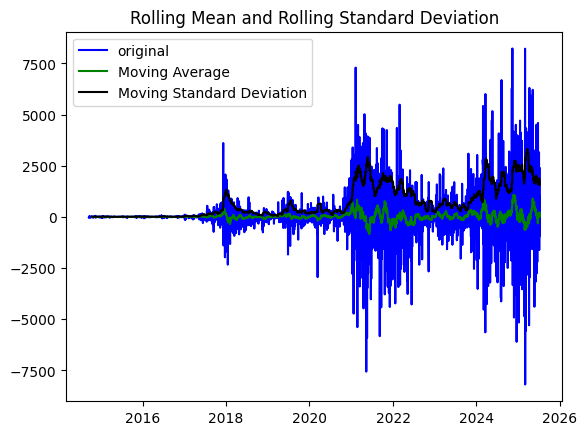

Results from Dickey Fueller

Test Statistic                -9.218883e+00
p-value                        1.802411e-15
'#Lags Used                    3.000000e+01
Number of Observations Used    3.914000e+03
Critical Value (1%)           -3.432022e+00
Critical Value (5%)           -2.862279e+00
Critical Value (10%)          -2.567163e+00
dtype: float64


In [15]:
df_diff.dropna(inplace=True)
test_stationary(df_diff)

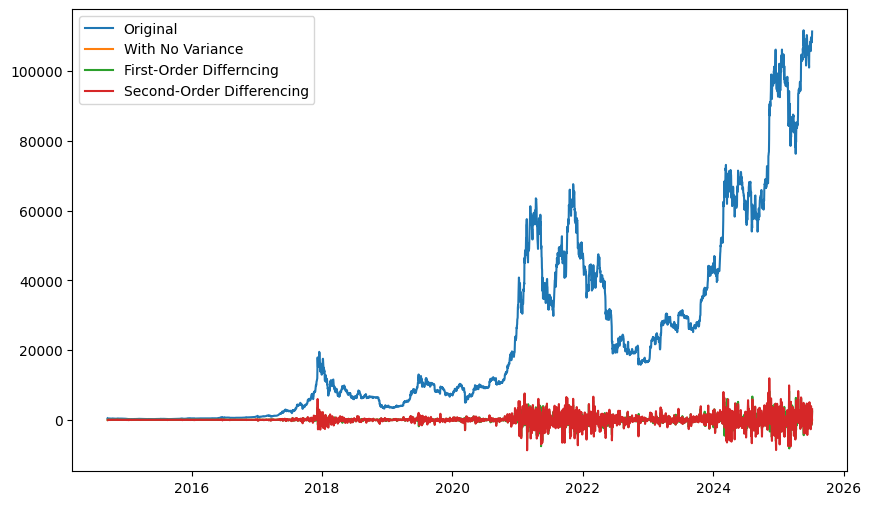

In [16]:
"""Second Order Differncing"""
df_diff2 = df.diff(2)

plt.figure(figsize=(10,6))
plt.plot(df,label="Original")
plt.plot(df_log,label="With No Variance")
plt.plot(df_diff,label="First-Order Differncing")
plt.plot(df_diff2,label="Second-Order Differencing")
plt.legend()
plt.show()


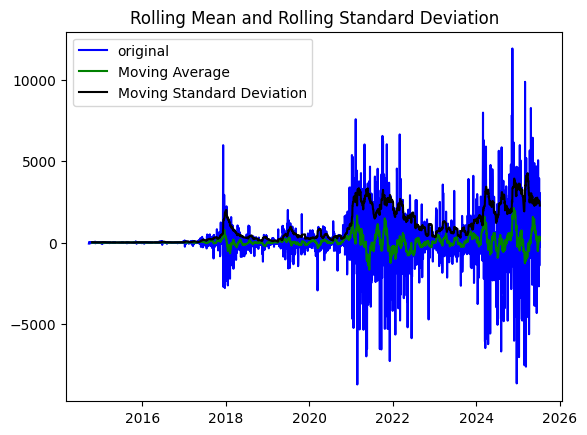

Results from Dickey Fueller

Test Statistic                -8.969722e+00
p-value                        7.813103e-15
'#Lags Used                    3.000000e+01
Number of Observations Used    3.913000e+03
Critical Value (1%)           -3.432022e+00
Critical Value (5%)           -2.862279e+00
Critical Value (10%)          -2.567163e+00
dtype: float64


In [17]:
""""Testing Stationary from second order differencing"""
df_diff2.dropna(inplace=True)
test_stationary(df_diff2)

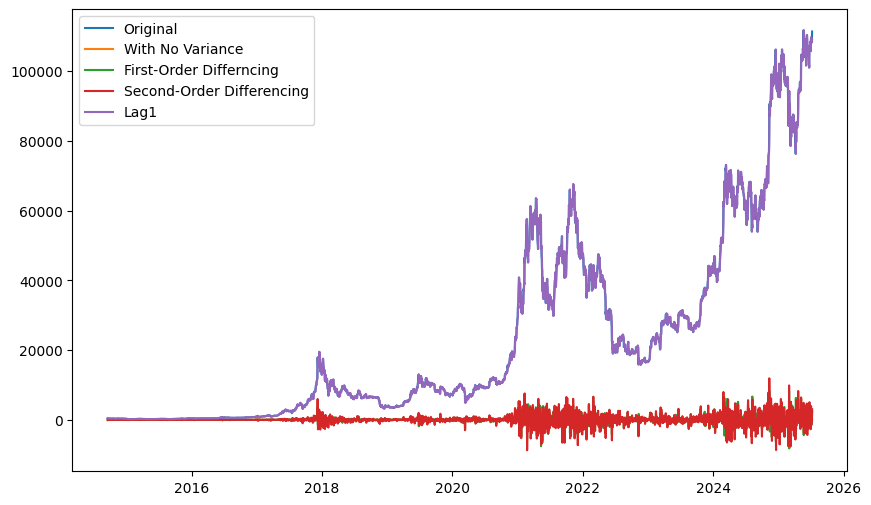

In [18]:
"""With a single lag"""
df_lag1 = df.shift(1)

plt.figure(figsize=(10,6))
plt.plot(df,label="Original")
plt.plot(df_log,label="With No Variance")
plt.plot(df_diff,label="First-Order Differncing")
plt.plot(df_diff2,label="Second-Order Differencing")
plt.plot(df_lag1,label="Lag1")
plt.legend()
plt.show()


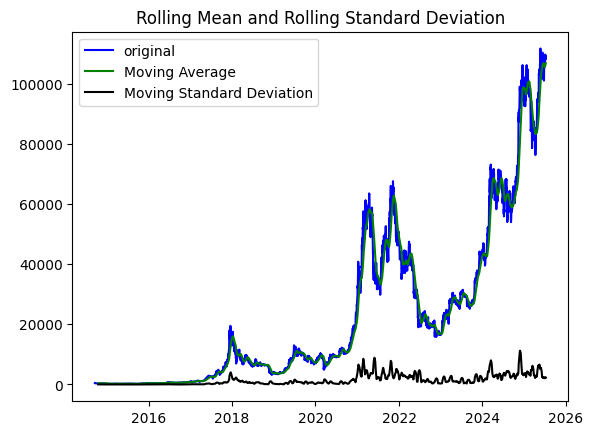

Results from Dickey Fueller

Test Statistic                    0.120505
p-value                           0.967434
'#Lags Used                      31.000000
Number of Observations Used    3913.000000
Critical Value (1%)              -3.432022
Critical Value (5%)              -2.862279
Critical Value (10%)             -2.567163
dtype: float64


In [19]:
"""Testing stationary of lag1"""

df_lag1.dropna(inplace=True)
test_stationary(df_lag1)


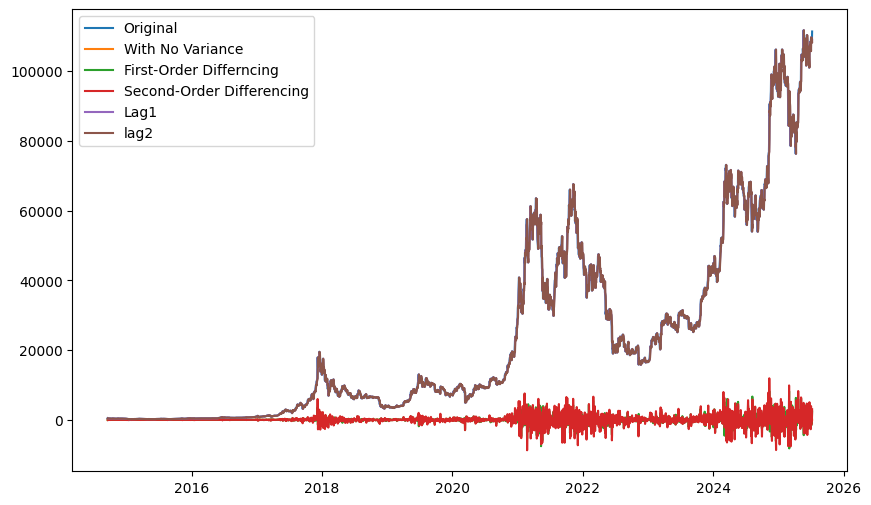

In [20]:
"""two lags"""

df_lag2 = df.shift(2)


plt.figure(figsize=(10,6))
plt.plot(df,label="Original")
plt.plot(df_log,label="With No Variance")
plt.plot(df_diff,label="First-Order Differncing")
plt.plot(df_diff2,label="Second-Order Differencing")
plt.plot(df_lag1,label="Lag1")
plt.plot(df_lag2,label="lag2")
plt.legend()
plt.show()


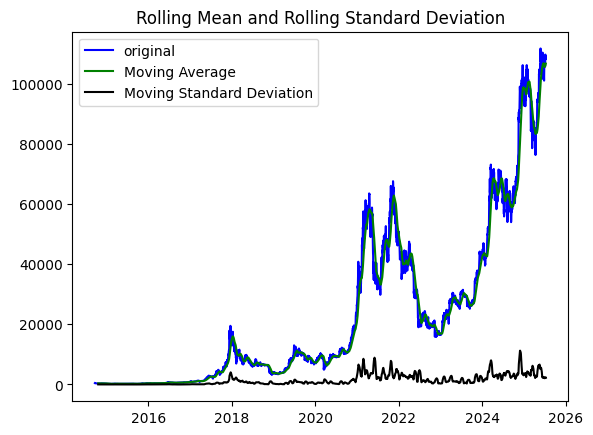

Results from Dickey Fueller

Test Statistic                    0.091961
p-value                           0.965508
'#Lags Used                      31.000000
Number of Observations Used    3912.000000
Critical Value (1%)              -3.432023
Critical Value (5%)              -2.862279
Critical Value (10%)             -2.567163
dtype: float64


In [21]:
df_lag2.dropna(inplace=True)
test_stationary(df_lag2)

In [22]:
df = create_values(df)
df.head(10)


X = df.drop('BTC-USD',axis=1)
y= df['BTC-USD']



X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)


scaler = MinMaxScaler(feature_range=(0,1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


""" A user-Defined function for metrics"""

def evaluate(y_test,pred,model_name,r2,mse,cv_scores):


    result = {
        "Model": model_name,
        "R2": r2,
        "RMSE": mse,
        "Cross-val Scores":cv_scores.mean()
    }

    return result


model_dict = []
models = {
    "LinearRegression":LinearRegression(),
    "lasso":Lasso(),
    "ridge":Ridge(),
    "GradientBoostingRegressor":GradientBoostingRegressor(),
    "BaggingRegressor":BaggingRegressor(),
    "xBGboostRegression":XGBRegressor(),
    "randomforest":RandomForestRegressor(),
}


for model_name,model in models.items():
    model.fit(X_train_scaled,y_train)
    pred = model.predict(X_test_scaled)
    mse = root_mean_squared_error(y_test,pred)
    r2 = r2_score(y_test,pred)
    cv_scores = cross_val_score(model, X_train_scaled,y_train,cv=10,scoring="neg_mean_squared_error")
    model_results = evaluate(y_test, pred, model_name,r2,mse,cv_scores)
    model_dict.append(model_results)



df_results = pd.DataFrame(model_dict)
print(df_results.head(10))







                       Model        R2          RMSE  Cross-val Scores
0           LinearRegression  0.690438  15601.055316     -2.363916e+08
1                      lasso  0.690398  15602.063900     -2.362525e+08
2                      ridge  0.690371  15602.750600     -2.362509e+08
3  GradientBoostingRegressor  0.985796   3341.785526     -1.126176e+07
4           BaggingRegressor  0.998833    957.747504     -9.700129e+05
5         xBGboostRegression  0.998412   1117.510982     -1.343592e+06
6               randomforest  0.999084    848.638460     -8.949730e+05


In [23]:
mlflow.set_experiment("Bitcoin-Boomer-strats-")

linearregression_params = {
'copy_X': [True,False], 
'fit_intercept': [True,False], 
'n_jobs': [1000,5000,10000], 
'positive': [True,False]}



lasso_params = {
    'alpha': [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]
    }


ridge_params = {
    'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]
    }



gradientboosting_params = {
    'n_estimators': [50,100,200],
    'learning_rate': [0.01,0.1,0.2],
    'max_depth': [3,4,5],
    'min_samples_split': [2,5,10]
    }

bagginregression_params = {
    'n_estimators': [50,100,200],
    'max_samples' : [1.0,0.8,0.6],
    'max_features': [1.0,0.8,0.6]
}



xgboost_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}


random_forest_params = {
    'n_estimators': [50,100,200],
    'min_samples_leaf':[1,2,4],
    'max_features': ['sqrt','log2',None],

}



models = {
    "LinearRegression":(LinearRegression(),linearregression_params),
    "lasso":(Lasso(),lasso_params),
    "ridge":(Ridge(),ridge_params),
    "GradientBoostingRegresser":(GradientBoostingRegressor(),gradientboosting_params),
    "baggingREgressor":(BaggingRegressor(),bagginregression_params),
    "xGBRegressor":(XGBRegressor(),xgboost_grid),
    "randomforestregressor":(RandomForestRegressor(),random_forest_params)
    }

best_scores = []

for model_name,(model,params) in models.items():
    grid_search = GridSearchCV(model,params,scoring="neg_root_mean_squared_error",cv=4,n_jobs=-1)
    grid_search.fit(X_train_scaled,y_train)
    print(f'Best Params for {model_name}: {grid_search.best_params_}')
    print(f'Best Score for {model_name}: {grid_search.best_score_}')
    best_scores.append({"Model":model_name,"neg_root_mean_squared_log_error":grid_search.best_score_})
    with mlflow.start_run(run_name=model_name):
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("best_score", grid_search.best_score_)
        mlflow.sklearn.log_model(grid_search.best_estimator_, model_name)
        best_scores.append({"Model": model_name, "Best Score": grid_search.best_score_})

2025/07/11 05:36:17 INFO mlflow.tracking.fluent: Experiment with name 'Bitcoin-Boomer-strats-' does not exist. Creating a new experiment.


Best Params for LinearRegression: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1000, 'positive': True}
Best Score for LinearRegression: -15401.766674748793


2025/07/11 05:36:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/11 05:36:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 05:36:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params for lasso: {'alpha': 1}
Best Score for lasso: -15390.927483809297


2025/07/11 05:36:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 05:36:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params for ridge: {'alpha': 1}
Best Score for ridge: -15390.801686750121


2025/07/11 05:36:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 05:36:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params for GradientBoostingRegresser: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Best Score for GradientBoostingRegresser: -1370.610915421984


2025/07/11 05:36:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 05:36:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params for baggingREgressor: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}
Best Score for baggingREgressor: -1042.8596370814455


2025/07/11 05:36:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 05:37:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params for xGBRegressor: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}
Best Score for xGBRegressor: -1213.3084076945686


2025/07/11 05:37:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/11 05:37:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Best Params for randomforestregressor: {'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 50}
Best Score for randomforestregressor: -1041.1810487613473


2025/07/11 05:37:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [24]:
model = RandomForestRegressor(max_features=None,min_samples_leaf=1,n_estimators=50)
model.fit(X_train_scaled,y_train)
pred = model.predict(X_test_scaled)
print(r2_score(y_test,pred))

0.9991006885739802


In [25]:
pred_vs_actual = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': pred
}, index=y_test.index)



pred_vs_actual.sort_index(inplace=True)
print('Predicted Vs Actual Prices\n')
print(pred_vs_actual)

print(pred_vs_actual.head(20))
print(pred_vs_actual.tail(20))



Predicted Vs Actual Prices

                   Actual      Predicted
Date                                    
2014-09-23     435.790985     412.662677
2014-09-25     411.574005     411.123528
2014-09-29     375.467010     383.793359
2014-10-01     383.614990     368.609275
2014-10-04     328.865997     351.161017
...                   ...            ...
2025-06-30  107135.335938  107916.055313
2025-07-01  105698.281250  109157.082187
2025-07-02  108859.320312  109199.886406
2025-07-04  108034.335938  109211.180469
2025-07-07  108299.851562  109018.151094

[790 rows x 2 columns]
                Actual   Predicted
Date                              
2014-09-23  435.790985  412.662677
2014-09-25  411.574005  411.123528
2014-09-29  375.467010  383.793359
2014-10-01  383.614990  368.609275
2014-10-04  328.865997  351.161017
2014-10-13  390.414001  381.253668
2014-10-16  382.556000  394.524664
2014-10-17  383.757996  392.651414
2014-10-19  389.545990  388.689294
2014-10-20  382.845001  387.57

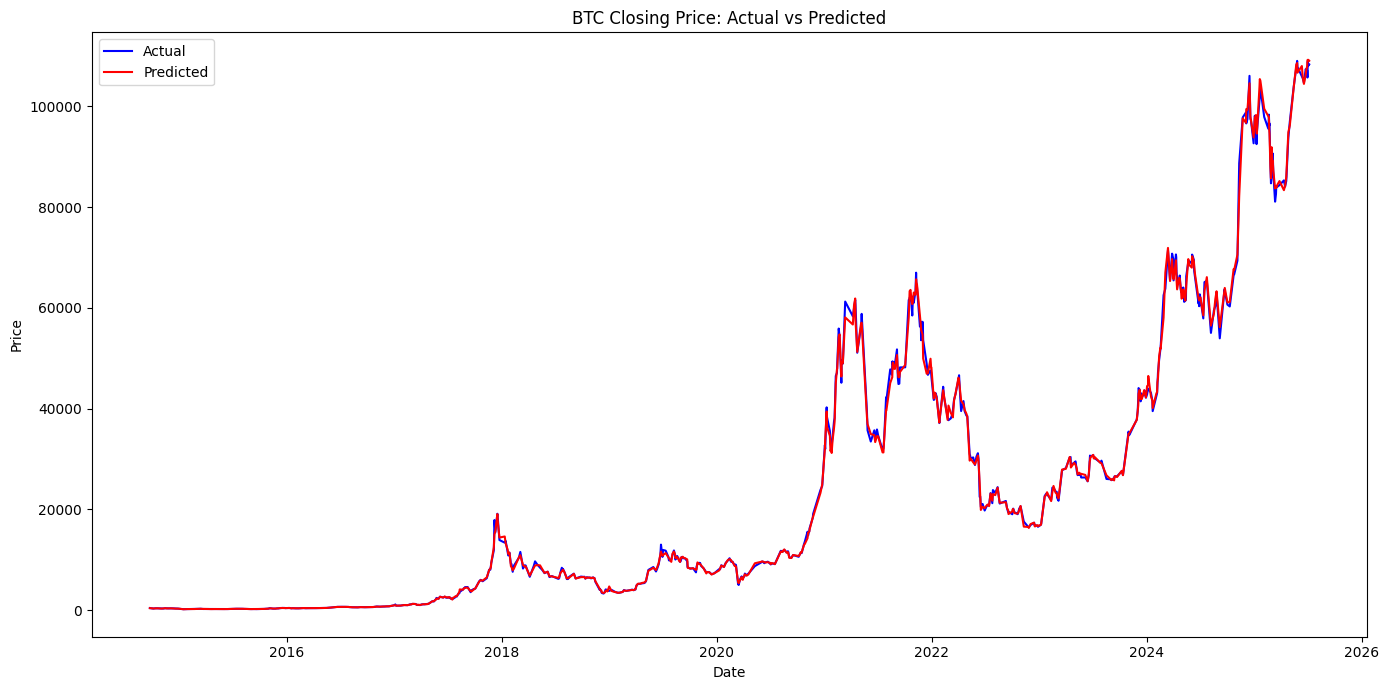

In [26]:
plt.figure(figsize=(14,7))
plt.plot(pred_vs_actual.index, pred_vs_actual['Actual'], label='Actual', color='blue')
plt.plot(pred_vs_actual.index, pred_vs_actual['Predicted'], label='Predicted', color='red')
plt.title('BTC Closing Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.savefig("images/best_traditonal_ml_model.png")
plt.show()

In [24]:
import pickle
with open("models/model.pkl","wb") as f:
    pickle.dump(model,f)




